In [1]:
import torch
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score, f1_score
from torch.utils.data import DataLoader, Subset
from torchvision import transforms
from torch.nn.functional import interpolate
import os
import sys
import mat73
sys.path.append("..")

from hsvit.dataset import BrainTumorDataset
from hsvit.utils import compute_classification_metrics
from hsvit.model import ViTBackbone
import torch.nn as nn
import torch.optim as optim

In [2]:
root_dir = "/Users/darshdave/Documents/BRAINTUMOR/DATASET/FILES/"
cvind_path = "/Users/darshdave/Documents/BRAINTUMOR/DATASET/cvind.mat"
model_dir = "/Users/darshdave/Documents/BRAINTUMOR/HSViT/model-weight/"
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [ ]:
cvinds = mat73.loadmat(cvind_path)['cvind']
test_ids = np.where(np.array(cvinds) == 3)[0]
train_ids = np.where(np.array(cvinds) == 1)[0]
val_ids = np.where(np.array(cvinds) == 2)[0]

In [4]:
class ResizedDataset(torch.utils.data.Dataset):
    def __init__(self, dataset, target_size=(224, 224)):
        self.dataset = dataset
        self.target_size = target_size

    def __len__(self):
        return len(self.dataset)

    def __getitem__(self, idx):
        image, label = self.dataset[idx]
        if image.shape[-1] != self.target_size[1]:
            image = interpolate(image.unsqueeze(0), size=self.target_size, mode='bilinear', align_corners=False).squeeze(0)
        return image, label

In [5]:
full_dataset = BrainTumorDataset(root_dir)
train_dataset = ResizedDataset(Subset(full_dataset, train_ids))
val_dataset = ResizedDataset(Subset(full_dataset, val_ids))
test_dataset = ResizedDataset(Subset(full_dataset, test_ids))

train_loader = DataLoader(train_dataset, batch_size=4, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=4, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=4, shuffle=False)

In [6]:
ablations = {
    "Full HSViT": ViTBackbone(use_clar=True, use_tcm=True, use_boundary_head=True),
    "No TCM": ViTBackbone(use_clar=True, use_tcm=False, use_boundary_head=True),
    "No Boundary Head": ViTBackbone(use_clar=True, use_tcm=True, use_boundary_head=False),
    "No CLAR": ViTBackbone(use_clar=False, use_tcm=True, use_boundary_head=True),
}

In [7]:
results = {}

for name, model in ablations.items():
    print(f"\n🧪 Training/Evaluating: {name}")
    model.to(device)

    optimizer = optim.Adam(model.parameters(), lr=1e-4)
    criterion_cls = nn.CrossEntropyLoss()
    criterion_bbox = nn.MSELoss()
    criterion_mask = nn.BCELoss()

    # Train for a few epochs
    model.train()
    for epoch in range(3):
        running_loss = 0.0
        for images, labels in train_loader:
            images, labels = images.to(device), labels.to(device) - 1

            logits, bbox, mask = model(images)
            loss = criterion_cls(logits, labels)
            if model.use_boundary_head:
                loss += criterion_mask(mask, torch.rand_like(mask))
            loss += criterion_bbox(bbox, torch.randn_like(bbox))
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            running_loss += loss.item()
        print(f"[Epoch {epoch+1}/3] Loss: {running_loss:.4f}")

    # Save model checkpoint
    torch.save(model.state_dict(), os.path.join(model_dir, f"{name.replace(' ', '_')}.pt"))

    # Evaluate on test set
    model.eval()
    all_preds, all_labels = [], []
    with torch.no_grad():
        for images, labels in test_loader:
            images = images.to(device)
            labels = labels.to(device) - 1
            logits, _, _ = model(images)
            preds = torch.argmax(logits, dim=1)
            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

    metrics = compute_classification_metrics(all_labels, all_preds)
    results[name] = metrics


🧪 Training/Evaluating: Full HSViT
[Epoch 1/3] Loss: 20.6256
[Epoch 2/3] Loss: 17.7676
[Epoch 3/3] Loss: 17.3386

🧪 Training/Evaluating: No TCM


/Users/darshdave/.pyenv/versions/3.10.1/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


[Epoch 1/3] Loss: 21.3867
[Epoch 2/3] Loss: 18.8180
[Epoch 3/3] Loss: 20.4516

🧪 Training/Evaluating: No Boundary Head


/Users/darshdave/.pyenv/versions/3.10.1/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


[Epoch 1/3] Loss: 15.1477
[Epoch 2/3] Loss: 14.0225
[Epoch 3/3] Loss: 10.0232

🧪 Training/Evaluating: No CLAR


/Users/darshdave/.pyenv/versions/3.10.1/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


[Epoch 1/3] Loss: 23.7775
[Epoch 2/3] Loss: 19.7914
[Epoch 3/3] Loss: 18.3115


/Users/darshdave/.pyenv/versions/3.10.1/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))



📊 Ablation Study Results:
                 Accuracy        F1 Precision Recall
Full HSViT            0.9  0.473684      0.45    0.5
No TCM                0.9  0.473684      0.45    0.5
No Boundary Head      0.9  0.473684      0.45    0.5
No CLAR               0.9  0.473684      0.45    0.5


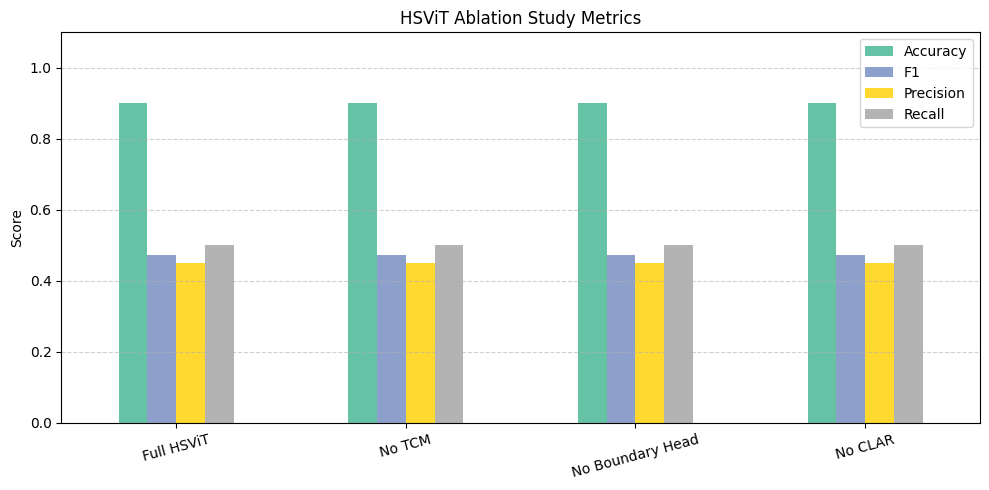

In [9]:
import pandas as pd
results_df = pd.DataFrame(results).T[['Accuracy', 'F1', 'Precision', 'Recall']]
print("\n📊 Ablation Study Results:")
print(results_df)

# Bar Plot
results_df.plot(kind='bar', figsize=(10, 5), colormap='Set2')
plt.title("HSViT Ablation Study Metrics")
plt.ylabel("Score")
plt.xticks(rotation=15)
plt.ylim(0, 1.1)
plt.grid(True, axis='y', linestyle='--', alpha=0.6)
plt.tight_layout()
plt.show()